In [70]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 5 2025

@author: Yaning
"""


import torch.optim as optim
import random
import torch
import torch.nn as nn
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import numpy as np

In [72]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_name = "meta-llama/Meta-Llama-3.1-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name)

In [14]:
with open('/home/yaning/Documents/LLM/skip_gram/h_book.txt', 'r') as file:
    h_text = file.read()

with open('/home/yaning/Documents/LLM/skip_gram/s_book.txt', 'r') as file:
    s_text = file.read()

In [15]:
h_text = h_text.lower()
s_text = s_text.lower()

In [404]:
s_text = "Haid geh ich in die Schdadt, um paar Eingaufn zu machn. Dann treffsch mich mit Feiern im Café un genießn e heeßn Gaffee. Es is'n schieener Tach, un ich freu mich offn Oobnd."
h_text = "Heute gehe ich in die Stadt, um ein paar Einkäufe zu machen. Danach treffe ich mich mit Freunden im Café und genieße einen heißen Kaffee. Es ist ein schöner Tag, und ich freue mich auf den Abend."

Generate Voaculary

In [16]:
# generate vocabulary dictionary
vocab_text = (s_text+h_text).lower()
vocab_text = re.findall(r'\b[\wäöüßéèàôûç]+\b', vocab_text)
# pre_vocab = word_tokenize(vocab_text)

dict_set = set(vocab_text)

In [17]:
word_to_index = {word: idx for idx, word in enumerate(dict_set)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

In [18]:
len(dict_set)

958

In [ ]:
# # decided to not use tokenizer
# s_token = tokenizer(s_text)["input_ids"]
# h_token = tokenizer(h_text)["input_ids"]

# plt.plot(s_token, label='Line 1', color='red') 
# plt.plot(h_token, label='Line 2', color='blue') 

Generate Training data

In [ ]:
# # separate the sentences
# s_sentences = re.split(r'[.,]', s_text[:-1])
# h_sentences = re.split(r'[.,]', h_text[:-1])

In [ ]:
# train_s = []
# for sentence in s_sentences:
#     temp = re.findall(r'\b[\wäöüßéèàôûç]+\b', sentence.lower())
#     train_s.append(temp)

# train_h = []
# for sentence in h_sentences:
#     temp = re.findall(r'\b[\wäöüßéèàôûç]+\b', sentence.lower())
#     train_h.append(temp)

In [ ]:
# want to try sentence by sentence but maybe not possibile with messy dataset

In [ ]:
# train_s_indx = []
# for sentence in train_s:
#     for word in sentence:
#         train_s_indx.append(word_to_index[word])

# train_h_indx = []
# for sentence in train_h:
#     for word in sentence:
#         train_h_indx.append(word_to_index[word])

In [19]:
train_h = re.sub(r'[.,\n]', " ", h_text)
train_s = re.sub(r'[.,\n]', " ", s_text)

In [20]:
train_h = re.findall(r'\b[\wäöüßéèàôûç]+\b', train_h)
train_s = re.findall(r'\b[\wäöüßéèàôûç]+\b', train_s)

In [21]:
window_size = 5

In [10]:
print(len(train_h))
print(len(train_s))

1470
1521


The pairs generating is important, which ones do you want to put in the same context

In [22]:
# transform them to indx
train_h_indx = []
for i in train_h:
    train_h_indx.append(word_to_index[i])

train_s_indx = []
for i in train_s:
    train_s_indx.append(word_to_index[i])

In [ ]:
# acc_s = []

# for i in range(len(train_s_indx)-window_size+1):
#     acc_s.append(train_s_indx[i:i+window_size])

In [23]:
acc_h = train_h_indx.copy()

In [ ]:
len(acc_s)

389

In [291]:
len(train_h_indx[1:11])

10

In [25]:
index_to_word[958] = 'PAD'
word_to_index['PAD'] = 958

In [26]:
len(word_to_index)

959

In [555]:
acc_h = []
ratio = len(train_h_indx)/len(train_s_indx)
for i in range(len(acc_s)):
    acc_h.append(train_h_indx[round(i*ratio)])

In [27]:
acc_s = []
ratio = len(train_s_indx)/len(train_h_indx)
for i in range(len(acc_h)):

    center = i*ratio
    chunk_begin = round(center - window_size/2)
    chunk_end = round(center + window_size/2)
    if chunk_end - chunk_begin != window_size:
        random_number = random.randint(0, 1)
        if random_number == 0:
            chunk_begin = chunk_begin+1
        else:
            chunk_end = chunk_end-1
    
    if chunk_begin < 0:
        chunk_begin = 0
    if chunk_end > len(train_s_indx)-1:
        chunk_end = len(train_s_indx)-1
    
    temp = train_s_indx[chunk_begin:chunk_end]
    while len(temp) != window_size:
        temp.append(958)
    acc_s.append(temp)
    # first = round(center - 1)
    # last = round(center + 1)
    # center = round(center)
    # # window size 2
    # center = (i+0.5)*ratio
    # first = round(center-0.5)
    # last = round(center+0.5)

    # # for window size 3
    # center = round((i+1)*ratio)
    # first = center - 1
    # last = center + 1

    # # window size 4
    # center = (i+1.5)*ratio
    # first = round(center-1.5)
    # second = round(center-0.5)
    # third = round(center+0.5)
    # last = round(center+1.5)
    # if first < 0:
    #     first = 0
    # if last > len(train_h_indx)-1:
    #     last = len(train_h_indx)-1

    # acc_h.append([train_h_indx[first], train_h_indx[center], train_h_indx[last]])
    # acc_h.append([train_h_indx[first], train_h_indx[second], train_h_indx[third], train_h_indx[last]])
    # acc_h.append([train_h_indx[first], train_h_indx[last]])
    

In [29]:
acc_s

[[423, 958, 958, 958, 958],
 [423, 138, 599, 410, 958],
 [423, 138, 599, 410, 574],
 [138, 599, 410, 574, 624],
 [599, 410, 574, 624, 380],
 [410, 574, 624, 380, 27],
 [574, 624, 380, 27, 813],
 [624, 380, 27, 813, 162],
 [380, 27, 813, 162, 66],
 [27, 813, 162, 66, 604],
 [813, 162, 66, 604, 934],
 [162, 66, 604, 934, 899],
 [66, 604, 934, 899, 842],
 [604, 934, 899, 842, 750],
 [934, 899, 842, 750, 645],
 [899, 842, 750, 645, 599],
 [842, 750, 645, 599, 711],
 [750, 645, 599, 711, 431],
 [645, 599, 711, 431, 828],
 [599, 711, 431, 828, 494],
 [711, 431, 828, 494, 955],
 [431, 828, 494, 955, 692],
 [828, 494, 955, 692, 416],
 [494, 955, 692, 416, 358],
 [955, 692, 416, 358, 86],
 [692, 416, 358, 86, 500],
 [416, 358, 86, 500, 588],
 [358, 86, 500, 588, 554],
 [86, 500, 588, 554, 679],
 [588, 554, 679, 510, 881],
 [554, 679, 510, 881, 719],
 [679, 510, 881, 719, 916],
 [510, 881, 719, 916, 105],
 [881, 719, 916, 105, 96],
 [719, 916, 105, 96, 599],
 [916, 105, 96, 599, 853],
 [105, 96,

In [30]:
train_data = list(zip(acc_h, acc_s))

In [31]:
train_data

[(691, [423, 958, 958, 958, 958]),
 (410, [423, 138, 599, 410, 958]),
 (468, [423, 138, 599, 410, 574]),
 (380, [138, 599, 410, 574, 624]),
 (927, [599, 410, 574, 624, 380]),
 (813, [410, 574, 624, 380, 27]),
 (187, [574, 624, 380, 27, 813]),
 (816, [624, 380, 27, 813, 162]),
 (604, [380, 27, 813, 162, 66]),
 (934, [27, 813, 162, 66, 604]),
 (899, [813, 162, 66, 604, 934]),
 (228, [162, 66, 604, 934, 899]),
 (750, [66, 604, 934, 899, 842]),
 (645, [604, 934, 899, 842, 750]),
 (691, [934, 899, 842, 750, 645]),
 (711, [899, 842, 750, 645, 599]),
 (431, [842, 750, 645, 599, 711]),
 (828, [750, 645, 599, 711, 431]),
 (494, [645, 599, 711, 431, 828]),
 (827, [599, 711, 431, 828, 494]),
 (85, [711, 431, 828, 494, 955]),
 (472, [431, 828, 494, 955, 692]),
 (416, [828, 494, 955, 692, 416]),
 (358, [494, 955, 692, 416, 358]),
 (582, [955, 692, 416, 358, 86]),
 (521, [692, 416, 358, 86, 500]),
 (588, [416, 358, 86, 500, 588]),
 (554, [358, 86, 500, 588, 554]),
 (679, [86, 500, 588, 554, 679]),
 

In [32]:
class Word2VecSkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGram, self).__init__()
        self.input_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output_embedding = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, center_word, context_word):
        # Get embeddings for center and context words
        center_embedding = self.input_embedding(center_word)  # Shape: (batch_size, embedding_dim)
        context_embedding = self.output_embedding(context_word)  # Shape: (batch_size, embedding_dim)
        
        # Compute dot product (similarity score)
        similarity = torch.mul(center_embedding, context_embedding).sum(dim=1)
        # similarity = torch.mul(center_embedding, context_embedding)
        # sum_similarity = torch.sum(similarity)
        return similarity

embedding_dim = 50
vocab_size = len(word_to_index)

model = Word2VecSkipGram(vocab_size=vocab_size, embedding_dim=embedding_dim)
print(model)


Word2VecSkipGram(
  (input_embedding): Embedding(959, 50)
  (output_embedding): Embedding(959, 50)
)


In [33]:
# Define the loss function
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super(NegativeSamplingLoss, self).__init__()
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, positive_similarity, negative_similarity):
        pos_loss = self.log_sigmoid(positive_similarity).mean()
        neg_loss = self.log_sigmoid(-negative_similarity).mean()
        return - (pos_loss + neg_loss)

learning_rate = 0.01
num_epochs = 150

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = NegativeSamplingLoss()

def get_negative_samples(vocab_size, batch_size, num_samples):
    return torch.randint(0, vocab_size, (batch_size, num_samples))
    

In [34]:
pairs = train_data

In [35]:
losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    random.shuffle(pairs)  # Shuffle pairs each epoch

    for center_idx, context_idx in pairs:
        # center_idx = torch.tensor([word_to_index[center_word]], dtype=torch.long)
        # context_idx = torch.tensor([word_to_index[context_word]], dtype=torch.long)
        # print(context_idx[1])
        center_idx = torch.tensor(center_idx)
        context_idx = torch.tensor([context_idx])
        # print(center_idx)
        # print(context_idx)
        positive_similarity = model(center_idx, context_idx)
        
        # Negative sampling
        negative_samples = get_negative_samples(vocab_size, 1, window_size)
        negative_similarity = model(center_idx, negative_samples.view(-1))
        
        # Calculate loss and update model
        loss = criterion(positive_similarity, negative_similarity)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    losses.append(total_loss)
    
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(pairs):.4f}")

100%|████████████████████████████████████████████████████████████████████████████| 150/150 [03:58<00:00,  1.59s/it]


In [36]:
losses[-1]

1595.2801213646308

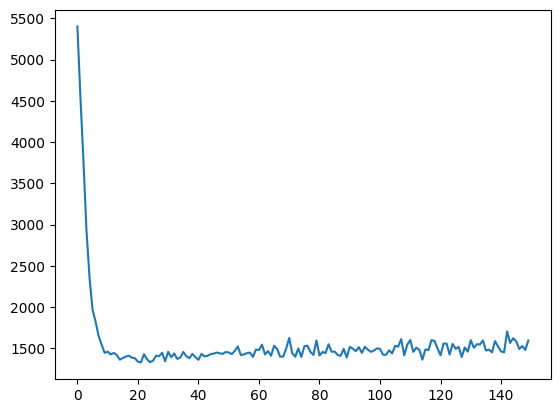

In [37]:
plt.plot(range(0,num_epochs), losses)

In [41]:
word_to_index

{'lebewohl': 0,
 'nothalasse': 1,
 'schließe': 2,
 'rannte': 3,
 'parker': 4,
 'schöne': 5,
 'unten': 6,
 'flur': 7,
 'abzuzäumen': 8,
 'gelegenheit': 9,
 'übrigens': 10,
 'erchine': 11,
 'berichtete': 12,
 'beviel': 13,
 'da': 14,
 'blicklich': 15,
 'niederwerfen': 16,
 'fassten': 17,
 'befestigt': 18,
 'gedämpfter': 19,
 'haben': 20,
 'stürzte': 21,
 'ihrem': 22,
 'ähne': 23,
 'erzählen': 24,
 'geladzt': 25,
 'sicher': 26,
 'kam': 27,
 'bis': 28,
 'brechtisches': 29,
 'eingestämt': 30,
 'traurte': 31,
 'demähen': 32,
 'letzten': 33,
 'meinetwegen': 34,
 'unterhaltsam': 35,
 'zur': 36,
 'machen': 37,
 'boden': 38,
 'blieb': 39,
 'weitem': 40,
 'spackte': 41,
 'ihn': 42,
 'löste': 43,
 'erst': 44,
 'suchen': 45,
 'erschienen': 46,
 'rettler': 47,
 'däuten': 48,
 'wurde': 49,
 'rechts': 50,
 'meinen': 51,
 'fing': 52,
 'gerät': 53,
 'jachde': 54,
 'ausgesucht': 55,
 'erhöhen': 56,
 'sprach': 57,
 'umgedreht': 58,
 'maultier': 59,
 'dödes': 60,
 'mitgedemmt': 61,
 'unter': 62,
 'holte': 

In [425]:
len(set(vocab_text))

52

In [42]:
# words_to_visualize = ['heit', 'heute', 'komm', 'komme', 'giehe', 'tog', 'tag']  # Replace with words from your vocabulary
# words_to_visualize = set(vocab_text)
words_to_visualize = ['ich', 'schöne', 'nestern', 'abzuzäumen']
# words_to_visualize = ['schdadt', 'stadt', 'heute', 'haid', 'ich']
word_indices = torch.tensor([word_to_index[word] for word in words_to_visualize], dtype=torch.long)
word_vectors = [model.input_embedding(word_idx).detach().numpy()  for word_idx in word_indices]

# Reduce dimensionality
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word_vectors)

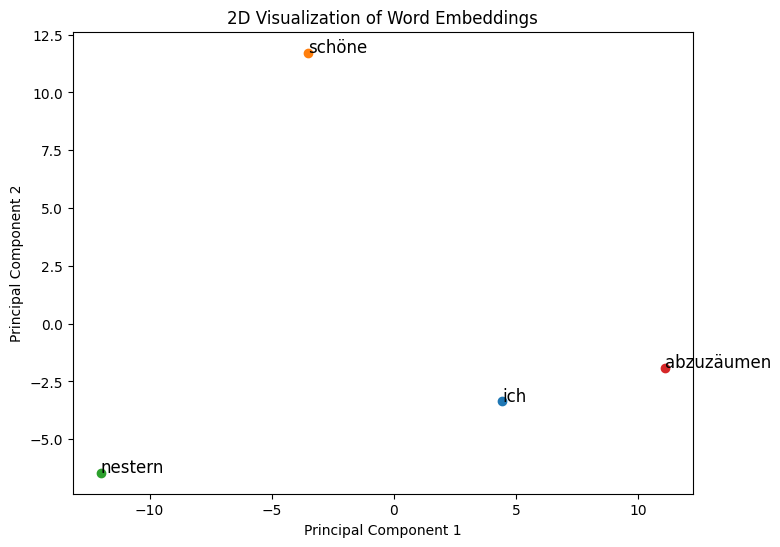

In [43]:
# Plot the word vectors
plt.figure(figsize=(8, 6))
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_vectors[i][0], reduced_vectors[i][1])
    plt.annotate(word, xy=(reduced_vectors[i][0], reduced_vectors[i][1]), fontsize=12)
plt.title("2D Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.savefig("embedding.png", dpi=300)
plt.show()


In [44]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [45]:
word_idx = word_to_index["abzuzäumen"]

In [46]:
target_embedding = model.input_embedding(torch.tensor(word_idx)).detach().numpy()

In [47]:
all_embeddings = model.input_embedding.weight.data.detach().numpy()

In [48]:
max_similarity = -1
for idx, embedding in enumerate(all_embeddings):
    if idx == word_idx:  # Skip the target embedding
        continue
    similarity = cosine_similarity(target_embedding, embedding)
    if similarity > max_similarity:
        max_similarity = similarity
        closest_word_idx = idx

In [49]:
index_to_word[closest_word_idx]

'ums'